#Install packages

In [1]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 108.6 MB/s eta 0:00:00


#Load data

urbanEVI_1990_perCountry.csv,
urbanEVI_2020_perCountry.csv

urbanNDVI_1990_perCountry.csv,
urbanNDVI_2020_perCountry.csv

# Maps and plots

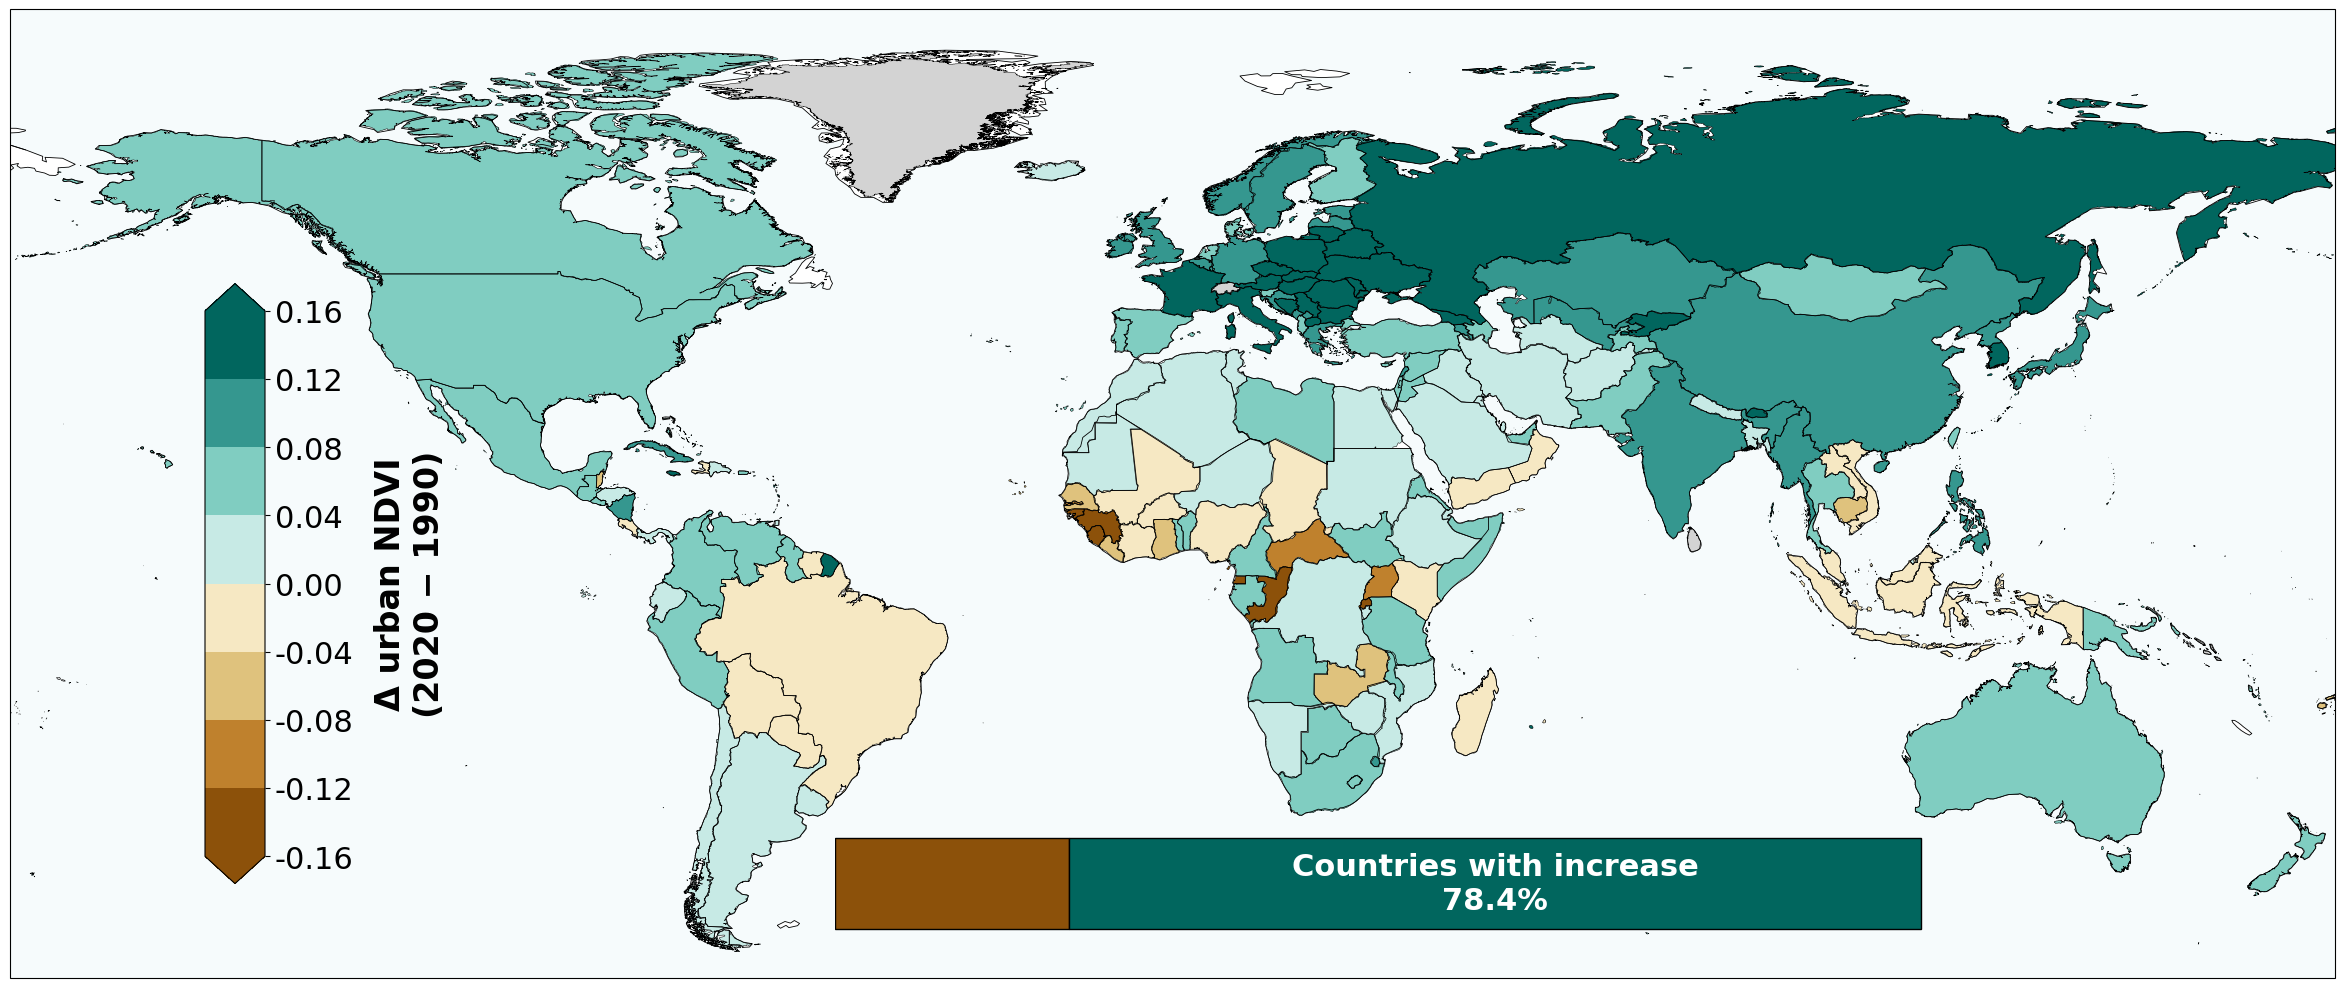

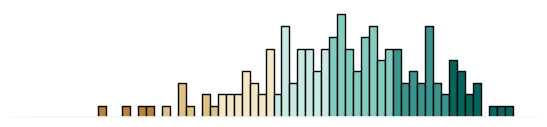

In [7]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# =========================
# CONFIG — edit these
# =========================
# Option A: leave as None if you already have `ndvi1990` and `ndvi2020` DataFrames in memory
PATH_1990   =  "/content/urbanNDVI_1990_perCountry.csv"
PATH_2020   =  "/content/urbanNDVI_2020_perCountry.csv"

GEOM_PATH = None

# Output files
MAP_OUT     = "SDFig4A_map.pdf"
HIST_OUT    = "SDFig4A_hist.pdf"

# Diverging palette (brown → white → green; white is the zero break separator, not used as a bin color)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',  # center (0) -> *boundary*, not a color step
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side
TEAL_RIGHT = '#01665e'  # positive side

# =========================
# Utilities
# =========================
def _split_center_palette(cols):
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]
    pos_cols = cols[mid+1:]
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

def _read_any_table(path):
    ext = (os.path.splitext(path)[1] or "").lower()
    if ext in [".csv", ".tsv"]:
        sep = "," if ext == ".csv" else "\t"
        return pd.read_csv(path, sep=sep)
    if ext in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    # Let GeoPandas try for GIS files
    try:
        return gpd.read_file(path)
    except Exception as e:
        raise RuntimeError(f"Could not read '{path}' as a geospatial file: {e}")

def _ensure_geometry(df, geom_path=None, df_label=""):
    """
    Return a GeoDataFrame with columns ['shapeName', 'geometry', ...].
    Priority:
    1) geometry column exists (already GeoDataFrame)
    2) .geo column with GeoJSON strings -> parse
    3) merge geometry from geom_path using 'shapeName'
    """
    # case 1: already has geometry as a GeoDataFrame
    if isinstance(df, gpd.GeoDataFrame) and 'geometry' in df.columns:
        return df

    # case 2: has geometry column (non-GeoDataFrame)
    if 'geometry' in df.columns:
        try:
            return gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
        except Exception as e:
            raise RuntimeError(f"{df_label}: invalid 'geometry' column: {e}")

    # case 3: has .geo column -> parse shapely geometries
    if '.geo' in df.columns:
        try:
            geom = df['.geo'].apply(lambda x: shape(json.loads(x)) if pd.notnull(x) else None)
            gdf = gpd.GeoDataFrame(df.drop(columns=['.geo']).assign(geometry=geom), geometry='geometry', crs="EPSG:4326")
            return gdf
        except Exception as e:
            raise RuntimeError(f"{df_label}: failed to parse '.geo' column into geometry: {e}")

    # case 4: merge from external geometry file
    if geom_path:
        if not os.path.exists(geom_path):
            raise FileNotFoundError(f"Geometry file not found: {geom_path}")
        shapes = _read_any_table(geom_path)
        if 'shapeName' not in shapes.columns:
            raise KeyError(f"Geometry file '{geom_path}' must contain a 'shapeName' column.")
        if 'geometry' not in shapes.columns:
            raise KeyError(f"Geometry file '{geom_path}' has no 'geometry' column.")
        # unique shapes
        shapes = shapes[['shapeName', 'geometry']].drop_duplicates('shapeName')
        merged = pd.merge(df, shapes, on='shapeName', how='left')
        if merged['geometry'].isna().all():
            raise RuntimeError("After merging with geometry, all geometries are NaN. Check 'shapeName' keys.")
        return gpd.GeoDataFrame(merged, geometry='geometry', crs="EPSG:4326")

    raise RuntimeError(
        f"{df_label}: No geometry found. Provide a '.geo' column, a 'geometry' column, or set GEOM_PATH."
    )

def _draw_percent_bar(fig, neg_pct, pos_pct,
                      neg_label="Decrease", pos_label="Increase",
                      box=[0.67, 0.18, 0.28, 0.05], fontsize=18):
    try:
        axb = fig.add_axes(box)
        axb.set_axis_off()
        neg_pct = max(0.0, float(neg_pct))
        pos_pct = max(0.0, float(pos_pct))
        total = neg_pct + pos_pct
        if total == 0:
            return
        axb.barh([""], [neg_pct], color=BROWN_LEFT, edgecolor="black", height=0.6)
        axb.barh([""], [pos_pct], color=TEAL_RIGHT, edgecolor="black", height=0.6, left=neg_pct)
        if neg_pct > 2:
            axb.text(neg_pct/2, 0, f"{neg_label}\n", ha="center", va="center",
                     fontsize=fontsize, color="white", weight="bold")
        if pos_pct > 2:
            axb.text(neg_pct + pos_pct/2, 0, f"{pos_label}\n{pos_pct:.1f}%", ha="center", va="center",
                     fontsize=fontsize, color="white", weight="bold")
        for s in axb.spines.values(): s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])
    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

def _create_histogram(valid_series, neg_cols, pos_cols, out_path=None, n_bins_half=30):
    arr = np.asarray(pd.to_numeric(valid_series, errors='coerce'), dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        print("Histogram: no valid data to plot."); return
    # Soft-robust span
    p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
    arr = arr[(arr >= p2_5) & (arr <= p97_5)]
    if arr.size == 0:
        print("Histogram: no data within 2.5–97.5 percentile."); return

    abs_max = max(abs(arr.min()), abs(arr.max()))
    if abs_max == 0: abs_max = 1e-6

    bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
    bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
    bins = np.concatenate([bins_left, bins_right])

    bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
    colors = neg_cols + pos_cols
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

    fig, ax = plt.subplots(figsize=(6.8, 1.4))
    counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)
    for patch, l, r in zip(patches, edges[:-1], edges[1:]):
        mid = 0.5*(l+r)
        patch.set_facecolor(cmap(norm(mid)))
    # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.2)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    if out_path:
        # os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=400, bbox_inches='tight')
    plt.show()

# =========================
# Main
# =========================
def main():
    # 1) Load inputs: from memory or from files
    have_mem_1990 = 'ndvi1990' in globals()
    have_mem_2020 = 'ndvi2020' in globals()

    if not have_mem_1990 or not have_mem_2020:
        if PATH_1990 is None or PATH_2020 is None:
            raise RuntimeError(
                "Inputs missing: Either define DataFrames `ndvi1990` and `ndvi2020` in memory, "
                "OR set PATH_1990 and PATH_2020 to readable files."
            )
        if not os.path.exists(PATH_1990):
            raise FileNotFoundError(f"PATH_1990 not found: {PATH_1990}")
        if not os.path.exists(PATH_2020):
            raise FileNotFoundError(f"PATH_2020 not found: {PATH_2020}")

        df1990 = _read_any_table(PATH_1990)
        df2020 = _read_any_table(PATH_2020)
    else:
        # Use in-memory variables
        df1990 = globals()['ndvi1990']
        df2020 = globals()['ndvi2020']

    # 2) Validate required columns
    for name, df in [('ndvi1990', df1990), ('ndvi2020', df2020)]:
        if 'shapeName' not in df.columns or 'mean' not in df.columns:
            raise KeyError(f"{name} must contain columns: 'shapeName' and 'mean'.")

    # 3) Geometry: we’ll carry geometry from the 2020 side
    gdf2020 = _ensure_geometry(df2020, geom_path=GEOM_PATH, df_label="ndvi2020")

    # 4) Aggregate by shapeName and compute change (2020 − 1990)
    try:
        group1990 = df1990.groupby('shapeName', as_index=False)['mean'].mean()
        group2020 = df2020.groupby('shapeName', as_index=False)['mean'].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping failed: {e}")

    merged = pd.merge(group1990, group2020, on='shapeName', suffixes=('_1990', '_2020'))
    merged['fraction_change'] = merged['mean_2020'] - merged['mean_1990']

    # 5) Join geometry
    geo_gdf = gdf2020.drop_duplicates(subset=['shapeName'])[['shapeName', 'geometry']]
    final_df = pd.merge(geo_gdf, merged[['shapeName', 'fraction_change']], on='shapeName', how='left')
    final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry', crs=gdf2020.crs)

    # 6) Colors & bounds
    neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    valid = final_gdf['fraction_change'].dropna()
    if valid.empty:
        raise ValueError("No valid 'fraction_change' values to plot.")

    # robust symmetric span
    abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
    if abs_max <= 0 or not np.isfinite(abs_max):
        abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

    bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
    colors = neg_cols + pos_cols
    cmap_discrete = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

    # 7) Map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    final_gdf.plot(
        column='fraction_change',
        ax=ax,
        cmap=cmap_discrete,
        norm=norm,
        edgecolor='black',
        linewidth=0.35,
        missing_kwds={'color': 'lightgrey', 'label': 'No data'}
    )

    # Colorbar
    cax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
    sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('Δ urban NDVI\n(2020 − 1990)', fontsize=24, labelpad=15, fontweight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    # 8) Percent bar (temporal semantics by default: negative=Decrease, positive=Increase)
    neg_pct = float((valid < 0).sum()) / float(valid.size) * 100.0
    pos_pct = float((valid > 0).sum()) / float(valid.size) * 100.0

    # If instead you are plotting URBAN−RURAL differences, change labels to:
    # _draw_percent_bar(fig, neg_pct, pos_pct, neg_label="Rural > Urban", pos_label="Urban > Rural")
    _draw_percent_bar(fig, neg_pct, pos_pct, neg_label="", pos_label="Countries with increase",
                      box=[0.4, 0.275, 0.38, 0.05], fontsize=22)


    # fig.add_axes([0.4, 0.25, 0.48, 0.05])

    # Save map
    # os.makedirs(os.path.dirname(MAP_OUT), exist_ok=True)
    plt.savefig(MAP_OUT, bbox_inches='tight', dpi=400)
    plt.show()

    # 9) Histogram
    _create_histogram(valid, neg_cols, pos_cols, out_path=HIST_OUT, n_bins_half=30)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        # Make failures obvious and informative
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)


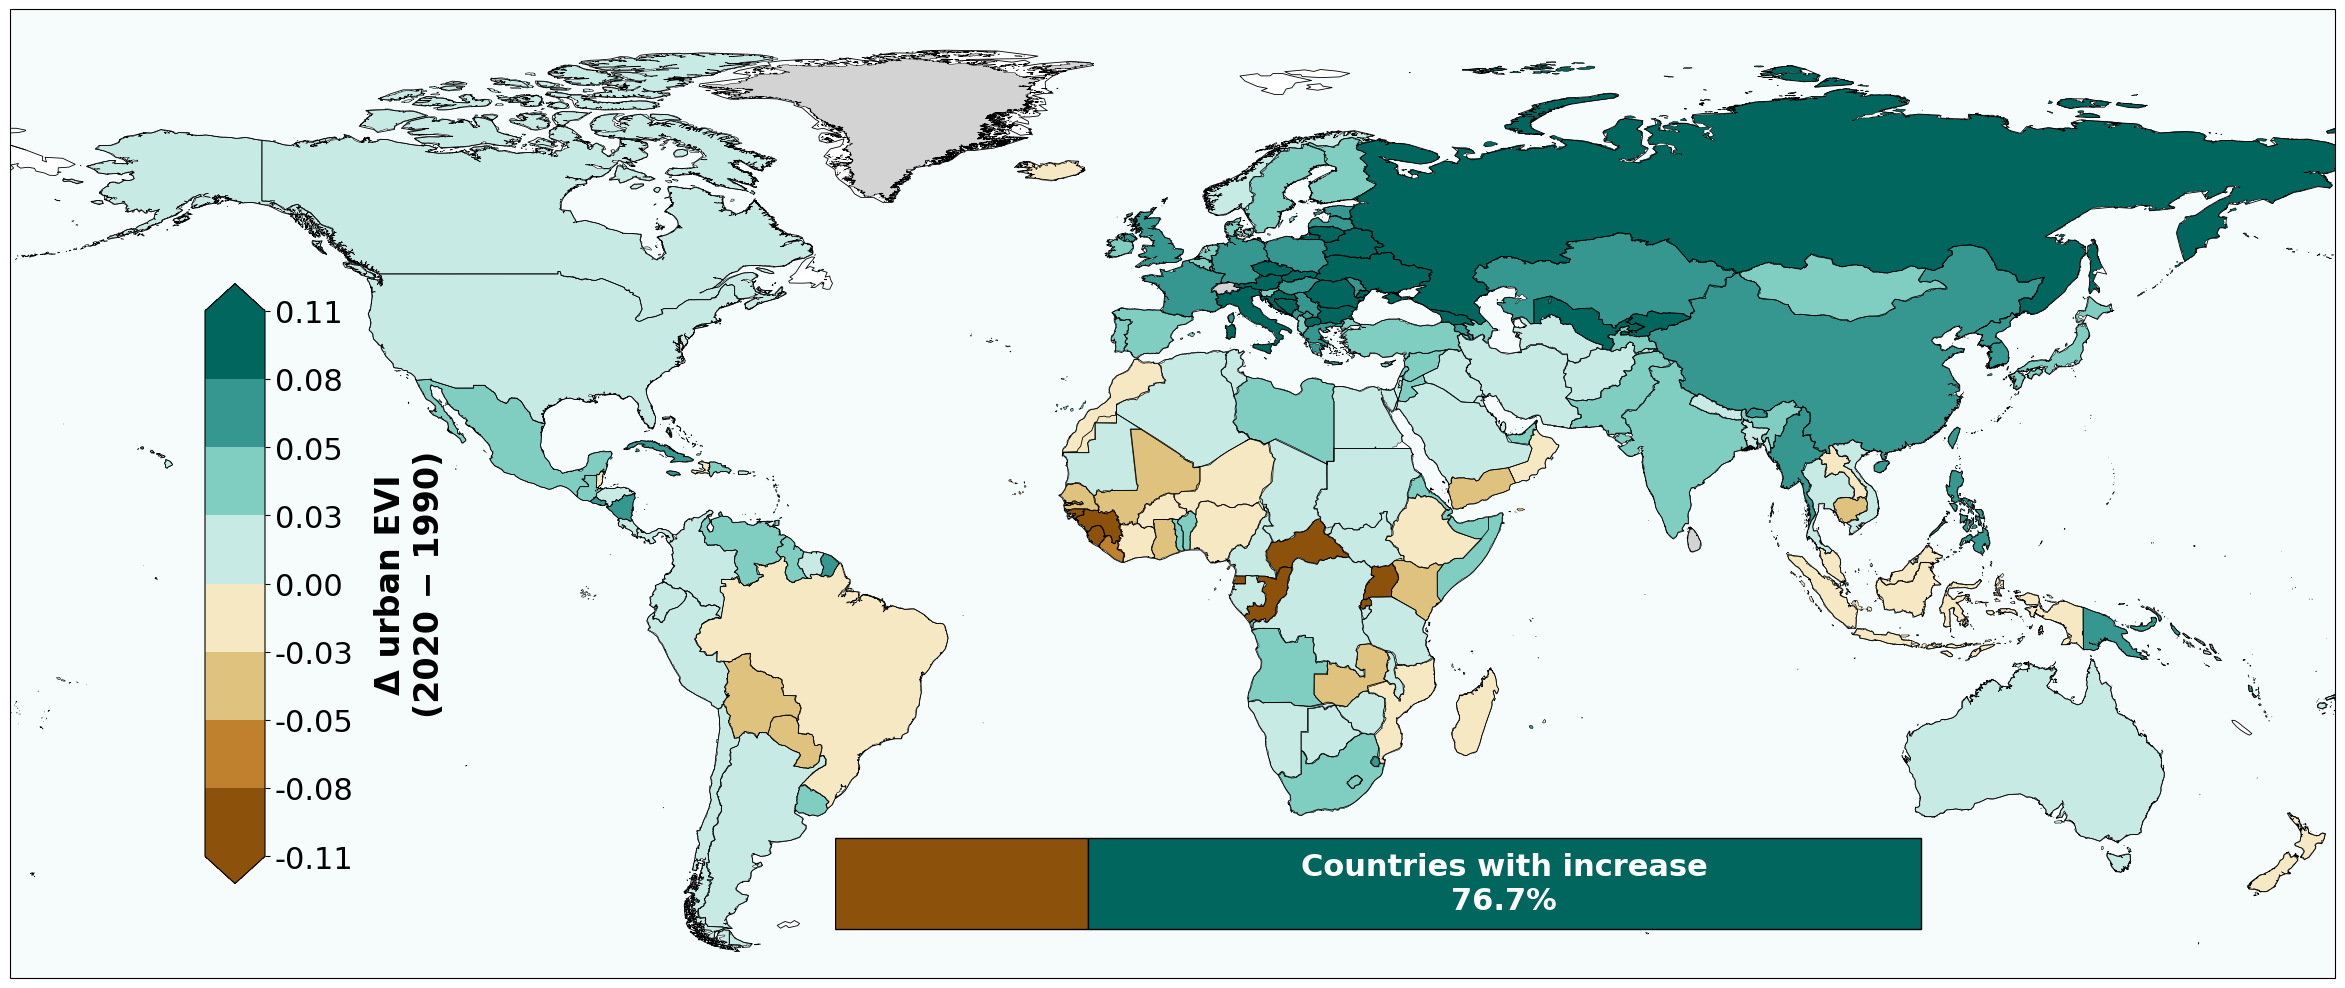

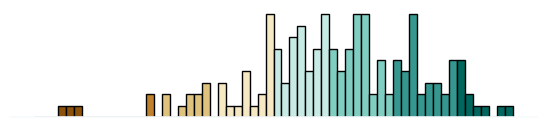

In [6]:
# =========================
# IMPORTS
# =========================
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# =========================
# CONFIG — edit these
# =========================
# Option A (files): leave as None to use in-memory DataFrames evi1990/evi2020
PATH_1990   =  "/content/urbanEVI_1990_perCountry.csv"
PATH_2020   =  "/content/urbanEVI_2020_perCountry.csv"

# Optional geometry source if your files/dataframes lack geometry
GEOM_PATH   =  None

# Outputs
MAP_OUT     = "/content/SDFig4B_map.pdf"
HIST_OUT    = "/content/SDFig4B_hist.pdf"

# Percent-bar labeling mode:
#   "temporal"  -> negative="Decrease", positive="Increase"   (use for 2020−1990 change)
#   "ur_diff"   -> negative="Rural > Urban", positive="Urban > Rural" (use for Urban−Rural differences)
PCT_BAR_MODE = "temporal"

# Diverging palette (brown → white → green; white is the zero break separator, not used as a bin color)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',  # center (0) -> *boundary*, not a color step
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side
TEAL_RIGHT = '#01665e'  # positive side

# =========================
# Utilities
# =========================
def _split_center_palette(cols):
    """Split symmetric diverging palette into (neg_cols, pos_cols), dropping the white center."""
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]
    pos_cols = cols[mid+1:]
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    """
    Exact 0 class break with symmetric span A = |abs_max|.
    Returns boundaries: [-A ... 0 | 0 ... +A]
    """
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

def _read_any_table(path):
    ext = (os.path.splitext(path)[1] or "").lower()
    if ext in [".csv", ".tsv"]:
        sep = "," if ext == ".csv" else "\t"
        return pd.read_csv(path, sep=sep)
    if ext in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    # Let GeoPandas try GIS formats (GeoJSON/Shapefile/etc.)
    try:
        return gpd.read_file(path)
    except Exception as e:
        raise RuntimeError(f"Could not read '{path}' as a geospatial file: {e}")

def _ensure_geometry(df, geom_path=None, df_label=""):
    """
    Return a GeoDataFrame with ['shapeName','geometry',...].
    Priority:
      1) already GeoDataFrame with geometry
      2) has 'geometry' column -> coerce
      3) has '.geo' column with GeoJSON -> parse
      4) merge from external geometry file (geom_path) on 'shapeName'
    """
    # case 1
    if isinstance(df, gpd.GeoDataFrame) and 'geometry' in df.columns:
        if df.crs is None:
            df = df.set_crs("EPSG:4326", allow_override=True)
        return df

    # case 2
    if 'geometry' in df.columns:
        try:
            gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
            return gdf
        except Exception as e:
            raise RuntimeError(f"{df_label}: invalid 'geometry' column: {e}")

    # case 3
    if '.geo' in df.columns:
        try:
            geom = df['.geo'].apply(lambda x: shape(json.loads(x)) if pd.notnull(x) else None)
            gdf = gpd.GeoDataFrame(df.drop(columns=['.geo']).assign(geometry=geom), geometry='geometry', crs="EPSG:4326")
            return gdf
        except Exception as e:
            raise RuntimeError(f"{df_label}: failed to parse '.geo' column into geometry: {e}")

    # case 4
    if geom_path:
        if not os.path.exists(geom_path):
            raise FileNotFoundError(f"Geometry file not found: {geom_path}")
        shapes = _read_any_table(geom_path)
        if 'shapeName' not in shapes.columns:
            raise KeyError(f"Geometry file '{geom_path}' must contain a 'shapeName' column.")
        if 'geometry' not in shapes.columns:
            raise KeyError(f"Geometry file '{geom_path}' has no 'geometry' column.")
        shapes = shapes[['shapeName', 'geometry']].drop_duplicates('shapeName')
        merged = pd.merge(df, shapes, on='shapeName', how='left')
        if merged['geometry'].isna().all():
            raise RuntimeError("After merging with geometry, all geometries are NaN. Check 'shapeName' keys.")
        return gpd.GeoDataFrame(merged, geometry='geometry', crs="EPSG:4326")

    raise RuntimeError(f"{df_label}: No geometry found. Provide a '.geo' or 'geometry' column, or set GEOM_PATH.")

def _draw_percent_bar(fig, neg_pct, pos_pct, mode="temporal",
                      box=[0.40, 0.275, 0.38, 0.05], fontsize=22):
    """
    Stacked % bar: left=negative, right=positive.
    mode="temporal": labels 'Decrease' and 'Increase'
    mode="ur_diff":  labels 'Rural > Urban' and 'Urban > Rural'
    """
    try:
        axb = fig.add_axes(box)
        axb.set_axis_off()
        neg_pct = max(0.0, float(neg_pct))
        pos_pct = max(0.0, float(pos_pct))
        total = neg_pct + pos_pct
        if total <= 0:
            return

        # Bars
        axb.barh([""], [neg_pct], color=BROWN_LEFT, edgecolor="black", height=0.6)
        axb.barh([""], [pos_pct], color=TEAL_RIGHT, edgecolor="black", height=0.6, left=neg_pct)

        # Labels
        if mode == "ur_diff":
            neg_label = ""
            pos_label = ""
        else:
            neg_label = ""
            pos_label = "Countries with increase"

        if neg_pct > 2:
            axb.text(neg_pct/2, 0, f"\n", ha="center", va="center",
                     fontsize=fontsize, color="white", weight="bold")
        if pos_pct > 2:
            axb.text(neg_pct + pos_pct/2, 0, f"{pos_label}\n{pos_pct:.1f}%", ha="center", va="center",
                     fontsize=fontsize, color="white", weight="bold")

        for s in axb.spines.values(): s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])
    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

def _create_histogram(valid_series, neg_cols, pos_cols, out_path=None, n_bins_half=30):
    """
    Color-matched histogram with exact 0 split; class bounds identical to the map.
    """
    arr = np.asarray(pd.to_numeric(valid_series, errors='coerce'), dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        print("Histogram: no valid data to plot."); return

    # Trim to central 95% for robust span
    p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
    arr = arr[(arr >= p2_5) & (arr <= p97_5)]
    if arr.size == 0:
        print("Histogram: no data within 2.5–97.5 percentile."); return

    abs_max = max(abs(arr.min()), abs(arr.max()))
    if abs_max == 0: abs_max = 1e-6

    # Dense histogram bins
    bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
    bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
    bins = np.concatenate([bins_left, bins_right])

    # Discrete class bounds/coloring (identical logic as the map)
    bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
    colors = neg_cols + pos_cols
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

    fig, ax = plt.subplots(figsize=(6.8, 1.4))
    counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)
    for patch, l, r in zip(patches, edges[:-1], edges[1:]):
        mid = 0.5*(l+r)
        patch.set_facecolor(cmap(norm(mid)))
    # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)

    # Minimalist styling
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.2)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=400, bbox_inches='tight')
    plt.show()

# =========================
# Main
# =========================
def main():
    # 1) Load inputs: from memory or from files
    have_mem_1990 = 'evi1990' in globals()
    have_mem_2020 = 'evi2020' in globals()

    if not have_mem_1990 or not have_mem_2020:
        if PATH_1990 is None or PATH_2020 is None:
            raise RuntimeError(
                "Inputs missing: Either define DataFrames `evi1990` and `evi2020` in memory, "
                "OR set PATH_1990 and PATH_2020 to readable files."
            )
        if not os.path.exists(PATH_1990):
            raise FileNotFoundError(f"PATH_1990 not found: {PATH_1990}")
        if not os.path.exists(PATH_2020):
            raise FileNotFoundError(f"PATH_2020 not found: {PATH_2020}")
        df1990 = _read_any_table(PATH_1990)
        df2020 = _read_any_table(PATH_2020)
    else:
        df1990 = globals()['evi1990']
        df2020 = globals()['evi2020']

    # 2) Validate required columns
    for name, df in [('evi1990', df1990), ('evi2020', df2020)]:
        if 'shapeName' not in df.columns or 'mean' not in df.columns:
            raise KeyError(f"{name} must contain columns: 'shapeName' and 'mean'.")

    # 3) Carry geometry from the 2020 dataframe or merge from GEOM_PATH
    gdf2020 = _ensure_geometry(df2020, geom_path=GEOM_PATH, df_label="evi2020")

    # 4) Aggregate by shapeName and compute change (2020 − 1990)
    try:
        group1990 = df1990.groupby('shapeName', as_index=False)['mean'].mean()
        group2020 = df2020.groupby('shapeName', as_index=False)['mean'].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping failed: {e}")

    merged = pd.merge(group1990, group2020, on='shapeName', suffixes=('_1990', '_2020'))
    merged['fraction_change'] = merged['mean_2020'] - merged['mean_1990']

    # 5) Join geometry
    geo_gdf = gdf2020.drop_duplicates(subset=['shapeName'])[['shapeName', 'geometry']]
    final_df = pd.merge(geo_gdf, merged[['shapeName', 'fraction_change']], on='shapeName', how='left')
    final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry', crs=gdf2020.crs)

    # 6) Colors & bounds with exact zero break
    neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    valid = final_gdf['fraction_change'].dropna()
    if valid.empty:
        raise ValueError("No valid 'fraction_change' values to plot.")

    # Robust symmetric span from the central 95% of |values|
    abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
    if abs_max <= 0 or not np.isfinite(abs_max):
        abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

    bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
    colors = neg_cols + pos_cols
    cmap_discrete = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

    # 7) Map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    final_gdf.plot(
        column='fraction_change',
        ax=ax,
        cmap=cmap_discrete,
        norm=norm,
        edgecolor='black',
        linewidth=0.35,
        missing_kwds={'color': 'lightgrey', 'label': 'No data'}
    )

    # Colorbar with all class boundaries (including 0 as a break)
    cax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
    sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('Δ urban EVI\n(2020 − 1990)', fontsize=24, labelpad=15, fontweight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    # 8) Percent bar
    neg_pct = float((valid < 0).sum()) / float(valid.size) * 100.0
    pos_pct = float((valid > 0).sum()) / float(valid.size) * 100.0
    _draw_percent_bar(fig, neg_pct, pos_pct, mode=PCT_BAR_MODE,
                      box=[0.40, 0.275, 0.38, 0.05], fontsize=22)

    # Save map
    os.makedirs(os.path.dirname(MAP_OUT), exist_ok=True)
    plt.savefig(MAP_OUT, bbox_inches='tight', dpi=400)
    plt.show()

    # 9) Histogram (same zero-break logic)
    _create_histogram(valid, neg_cols, pos_cols, out_path=HIST_OUT, n_bins_half=30)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        # Make failures obvious and informative
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)
